# Offset free nonlinear MPC

In [1]:
import do_mpc
from casadi import SX, vertcat
import numpy as np
import matplotlib.pyplot as plt
import joblib

loaded_setup = joblib.load("sim_setup.pkl")


def get_model():
    model_type = 'continuous'
    model = do_mpc.model.Model(model_type)

    # States
    h1 = model.set_variable(var_type='_x', var_name='h1')
    h2 = model.set_variable(var_type='_x', var_name='h2')

    # Input
    u1 = model.set_variable(var_type='_u', var_name='u1')
    u2 = model.set_variable(var_type='_u', var_name='u2')
    
    # Parameters
    A1 = 1
    A2 = 0.5
    k1 = 0.5
    k2 = 0.8
    
    delta_h = h1 - h2
    flow12 = k1 * SX.sign(delta_h) * SX.sqrt(SX.fabs(delta_h))
    
    # Differential equations
    dh1_dt = (-flow12 + u1)/A1
    dh2_dt =  (flow12 - k2 * (h2**0.5) + u2)/A2

    model.set_rhs('h1', dh1_dt)
    model.set_rhs('h2', dh2_dt)

    model.setup()

    return model


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


In [2]:
def get_mpc(model, reference):
    mpc = do_mpc.controller.MPC(model)

    setup_mpc = {
        'n_horizon': loaded_setup["N"],
        't_step': 1.0,
        'state_discretization': 'collocation',
        'collocation_type': 'radau',
        'collocation_deg': 2,
        'collocation_ni': 2,
        'store_full_solution': True,
    }

    mpc.set_param(**setup_mpc)

    # Objective: track h1 and h2 to their references
    weight_h1 = loaded_setup["Qy"][0,0]/0.79368273  # Weight for h1
    weight_h2 = loaded_setup["Qy"][1,1]/0.52258528  # Weight for h2
    h1_ref = reference[0]     # Reference for h1
    h2_ref = reference[1]     # Reference for h2

    mterm = (weight_h1 * (model.x['h1'] - h1_ref)**2 + weight_h2 * (model.x['h2'] - h2_ref)**2)*0
    lterm = weight_h1 * (model.x['h1'] - h1_ref)**2 + weight_h2 * (model.x['h2'] - h2_ref)**2

    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(u1=loaded_setup["Qu"][0,0]/0.02223645, u2=loaded_setup["Qu"][1,1]/0.08454784)  # Small penalty on input moves for both u1 and u2
    # Constraints
    mpc.bounds['lower', '_u', 'u1'] = 0.0
    mpc.bounds['upper', '_u', 'u1'] = 0.5
    mpc.bounds['lower', '_u', 'u2'] = 0.0
    mpc.bounds['upper', '_u', 'u2'] = 1.0

    # Setup
    mpc.setup()

    return mpc


In [3]:
import do_mpc

def get_simulator(model):
    simulator = do_mpc.simulator.Simulator(model)

    params_simulator = {
        't_step': 1
    }

    simulator.set_param(**params_simulator)

    simulator.setup()

    return simulator


In [4]:
import matplotlib.pyplot as plt
import numpy as np

class Visualizer:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.lines = []
        self.ax.set_xlabel('Time [s]')
        self.ax.set_ylabel('Tank heights')
        self.ax.grid()

    def update(self, data):
        h1 = data['_x']['h1']
        h2 = data['_x']['h2']
        t = data['_time']

        if not self.lines:
            self.lines.append(self.ax.plot(t, h1, label='h1')[0])
            self.lines.append(self.ax.plot(t, h2, label='h2')[0])
            self.ax.legend()
        else:
            self.lines[0].set_data(t, h1)
            self.lines[1].set_data(t, h2)

        self.ax.relim()
        self.ax.autoscale()

        plt.pause(0.01)


In [5]:

model = get_model()
mpc = get_mpc(model, reference=loaded_setup["reference_ns"][:,0])
simulator = get_simulator(model)
#visualizer = Visualizer()

x0 = loaded_setup["y_start_ns"]  # Initial tank heights
u0 = loaded_setup['u_previous_ns']
mpc.x0 = x0
mpc.u0 = u0
simulator.x0 = x0

mpc.set_initial_guess()

n_steps = loaded_setup["sim_time"]
time_history = [0]
h1_history = [x0[0].item()]
h2_history = [x0[1].item()]
u_history = [u0.flatten().tolist()]  # Include initial control inputs

for k in range(1, n_steps + 1):
    if k%100 == 0 and k < n_steps:
        mpc = get_mpc(model, reference=loaded_setup["reference_ns"][:,k])
        #simulator = get_simulator(model)
        #visualizer = Visualizer()

        x0 = np.array([h1_history[-1], h2_history[-1]])
        mpc.x0 = x0
        mpc.u0 = np.array(u_history[-1])
        simulator.x0 = x0

        mpc.set_initial_guess()
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)

    time_history.append(k * 1)
    h1_history.append(x0[0].item())
    h2_history.append(x0[1].item())
    u_history.append(u0.flatten().tolist())  # Store control inputs

    x0 = y_next

    # data = {
    #     '_time': np.array(time_history),
    #     '_x': {
    #         'h1': np.array(h1_history),
    #         'h2': np.array(h2_history)
    #     }
    # }

    # visualizer.update(data)

plt.show()




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1042
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      358

Total number of variables............................:      334
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:      282
Total number of inequality c

In [6]:
k

500

In [7]:
loaded_setup["reference_ns"][:,k-1]

array([1. , 0.9])

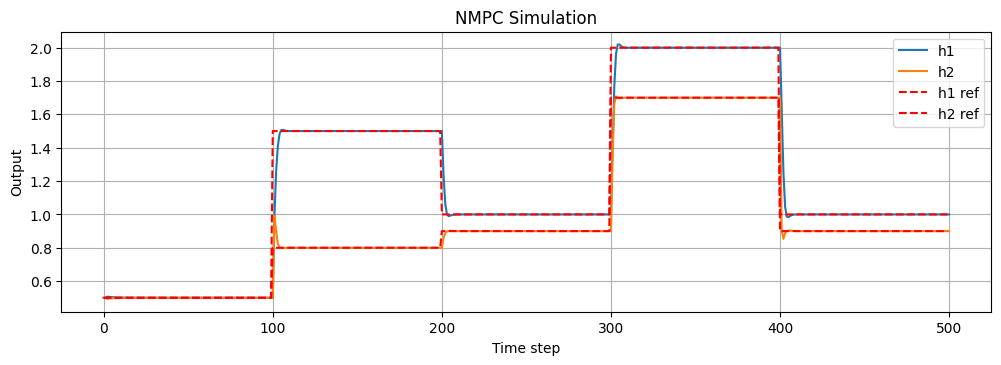

In [8]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(h1_history, label='h1')
plt.plot(h2_history, label='h2')
plt.plot(loaded_setup["reference_ns"][0,:n_steps],'r--', label='h1 ref')
plt.plot(loaded_setup["reference_ns"][1,:n_steps],'r--', label='h2 ref')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.title('NMPC Simulation')
plt.legend()
plt.grid(True)

In [9]:
u_history = np.array(u_history)

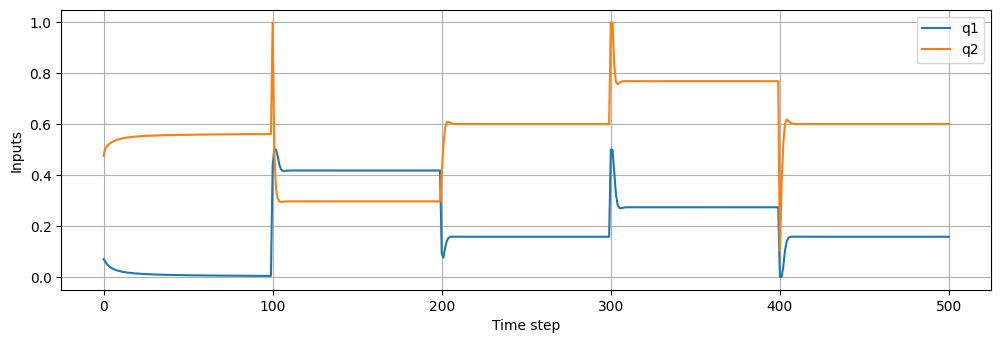

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_history.T[0], label='q1')
plt.plot(u_history.T[1], label='q2')
plt.xlabel('Time step')
plt.ylabel('Inputs')
plt.legend()
plt.grid(True) 

In [11]:
import joblib
scaler = joblib.load('../data/scaler.pkl')
scalerU = joblib.load('../data/scalerU.pkl')

In [12]:
# Compute the closed-loop value of the objective function
y_sim = scaler.transform(np.array([h1_history, h2_history]).T).T
u_sim = scalerU.transform(np.array(u_history).reshape(-1, 2)).T
Qy = loaded_setup["Qy"]  # Weights for h1 and h2
Qu = loaded_setup["Qu"]  # Weights for u1 and u2
n_steps = 500
objective_value = 0
for k in range(n_steps):
    y_diff = y_sim[:, k] - loaded_setup["reference"][:, k]
    u_diff = u_sim[:, k] - u_sim[:, k-1] if k > 0 else np.zeros(2)
    objective_value += y_diff.T @ Qy @ y_diff 
    objective_value += u_diff.T @ Qu @ u_diff
    #print(f"Objective value at step {k}: {objective_value}")
print(f"Closed-loop objective function value: {objective_value}")

Closed-loop objective function value: 47.552624482118745


In [13]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[0] - y_setpoint[0]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

NameError: name 'y_setpoint' is not defined

In [ ]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[1] - y_setpoint[1]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

No sustained convergence found.


In [ ]:
scaler.scale_**2

array([0.78450391, 0.51157423])

In [ ]:
y_sim[:,5]-y_setpoint

array([-1.1204003 , -0.42706358])

In [ ]:
y_setpoint

array([ 0.29135356, -0.22285209])

In [ ]:
k=1
u_sim[:, k] - u_sim[:, k-1]

array([-0.01606577,  0.04949643])

In [ ]:
u_sim

array([[-1.00522721, -1.02129298, -1.04393973, ..., -0.4174152 ,
        -0.4174152 , -0.4174152 ],
       [-0.08180042, -0.03230399, -0.00579007, ...,  0.34799897,
         0.34799897,  0.34799897]])